In [1]:
import numpy as np
import pandas as pd
import pickle
import time
from KNN_Shapley import get_VN, get_true_KNN, compute_KNN_shapley, compute_KNN_Asymmetric_Shapley, KNN_LOO
from performance_plot import removing_sequential_data, adding_sequential_data, final_plot

In [2]:
# Load data
i_sample = 0
num_samples_per_class_trn, num_samples_per_class_tst = 100, 50
shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit = 0.0625, 0.0625, 0.1, 45
param_setting = "num_samples_per_class_trn={}_num_samples_per_class_tst={}_shift_dx={}_shift_dy={}_scale={}_rotate={}".format(num_samples_per_class_trn, num_samples_per_class_tst, shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit)

with open("data/mnist_balanced_sample 2/augmented_sample{}_".format(i_sample+1) + param_setting + ".pickle", "rb") as fp:
    mydict = pickle.load(fp)
    
X_ori = mydict['X_ori']
y_ori = mydict['y_ori'].astype('int64')
X_aug = mydict['X_aug']
y_aug = mydict['y_aug'].astype('int64')
X_ori_aug = mydict['X_ori_aug']
y_ori_aug = mydict['y_ori_aug'].astype('int64')
X_val = mydict['X_val']
y_val = mydict['y_val'].astype('int64')

s_class_dic = {0:np.asarray(range(len(X_ori))), 
               1:np.asarray(range(len(X_ori), len(X_ori_aug)))}

## Part. 2 Realistic Data Augmentation Case

Perform realistic/meaningful data augmentation based on the original training set and show how SV / ASV allocates values to data creators and data packagers in the data market.

2.1 Train model with $D$. Compute SV and ASV.

2.2 Train model with $D\cup D^{\prime}$. Compute SV and ASV.

2.3 Plot histograms for SV.

2.4 Plot histograms for ASV.

### 2.1

In [3]:
K = 5
directory = 'experiments/fair allocation in data market/MNIST/realistic data augmentation/'
X_train_1 = X_ori
y_train_1 = y_ori

# train knn classifier
X_train_knn_gt_1 = get_true_KNN(X_train_1, X_val)

100%|████████████████████████████████████████| 500/500 [00:00<00:00, 725.30it/s]


In [4]:
# Compute SV
start = time.time()
knn_shaps = compute_KNN_shapley(y_train_1, X_train_knn_gt_1, y_val, K)
end = time.time()
print("Time to compute the exact symmetric shapley values for all data:", end - start)
np.save(directory + 'ori_knn_sv_K={}_'.format(K) + param_setting, knn_shaps)

100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1190.12it/s]

Time to compute the exact symmetric shapley values for all data: 0.4213550090789795


In [5]:
# Compute ASV
s_class_dic = {0:np.asarray(range(len(X_ori)))}

start = time.time()
knn_asym_shaps = compute_KNN_Asymmetric_Shapley(y_train_1, X_train_knn_gt_1, y_val, K, 
                                                s_class_dic)
end = time.time()
print("Time to compute the exact asymmetric shapley values for all data:", end - start)
np.save(directory + 'ori_knn_asv_K={}_'.format(K) + param_setting, knn_asym_shaps)

100%|████████████████████████████████████████| 500/500 [00:01<00:00, 359.30it/s]

Time to compute the exact asymmetric shapley values for all data: 1.3925530910491943


### 2.2

In [6]:
K = 5
directory = 'experiments/fair allocation in data market/MNIST/realistic data augmentation/'
X_train_2 = X_ori_aug
y_train_2 = y_ori_aug

# train knn classifier
X_train_knn_gt_2 = get_true_KNN(X_train_2, X_val)

100%|████████████████████████████████████████| 500/500 [00:01<00:00, 384.74it/s]


In [7]:
# all(y_train_2[:len(X_ori)] == y_train_2[len(X_ori):len(X_ori)*2]) # Sanity check

In [8]:
X_train_knn_gt_2.shape, y_train_2.shape # Sanity check

((500, 1000), (1000,))

In [9]:
# Compute SV
start = time.time()
knn_shaps = compute_KNN_shapley(y_train_2, X_train_knn_gt_2, y_val, K)
end = time.time()
print("Time to compute the exact symmetric shapley values for all data:", end - start)
np.save(directory + 'ori_aug_knn_sv_K={}_'.format(K) + param_setting, knn_shaps)

100%|████████████████████████████████████████| 500/500 [00:00<00:00, 607.35it/s]

Time to compute the exact symmetric shapley values for all data: 0.8244500160217285


In [10]:
# Compute ASV
s_class_dic = {0:np.asarray(range(len(X_ori))), 
               1:np.asarray(range(len(X_ori), len(X_train_2)))}

start = time.time()
knn_asym_shaps = compute_KNN_Asymmetric_Shapley(y_train_2, X_train_knn_gt_2, y_val, K, 
                                                s_class_dic)
end = time.time()
print("Time to compute the exact asymmetric shapley values for all data:", end - start)
np.save(directory + 'ori_aug_knn_asv_K={}_'.format(K) + param_setting, knn_asym_shaps)

100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 78.53it/s]

Time to compute the exact asymmetric shapley values for all data: 8.363495111465454


### 2.3

In [11]:
# Load SV and ASV
ori_sv = np.load(directory + 'ori_knn_sv_K={}_'.format(K) + param_setting + '.npy')
ori_aug_sv = np.load(directory + 'ori_aug_knn_sv_K={}_'.format(K) + param_setting + '.npy')

ori_asv = np.load(directory + 'ori_knn_asv_K={}_'.format(K) + param_setting + '.npy')
ori_aug_asv = np.load(directory + 'ori_aug_knn_asv_K={}_'.format(K) + param_setting + '.npy')

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_directory = 'experiments/fair allocation in data market/MNIST/realistic data augmentation/figures/'

In [13]:
# Sanity check

all(ori_sv == ori_asv), sum(ori_sv), sum(ori_asv)

(True, 0.7632000000000005, 0.7632000000000005)

In [14]:
# Sanity check

sum(ori_aug_sv), sum(ori_aug_asv)

(0.7576000000000003, 0.7576000000000009)

In [15]:
g = [i for i in range(len(ori_sv))]

# rank sv from high to low
ori_sv_idx = np.argsort(ori_sv)[::-1] 
ori_high_sv = ori_sv[ori_sv_idx]

In [16]:
sum(ori_sv), sum(ori_high_sv)

(0.7632000000000005, 0.7632000000000002)

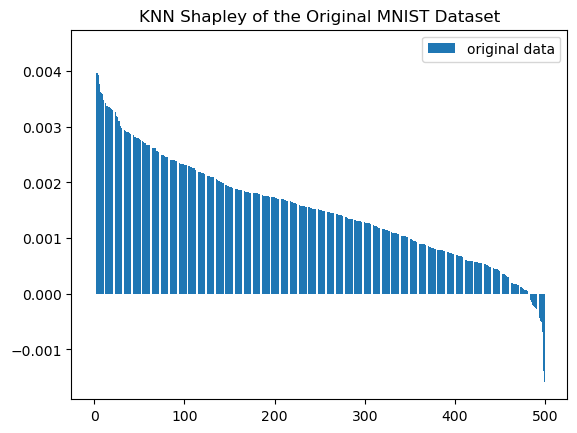

In [17]:
plt.bar(g, ori_high_sv, label='original data')
plt.title('KNN Shapley of the Original MNIST Dataset')
plt.legend()
plt.show()

In [18]:
g = [i for i in range(len(ori_sv))]

# rank sv from high to low
ori_sv_idx = np.argsort(ori_aug_sv[:len(X_ori)])[::-1] 
aug_sv_idx = ori_sv_idx + len(X_ori)

ori_high_sv = ori_aug_sv[ori_sv_idx]
aug_high_sv = ori_aug_sv[aug_sv_idx]

In [19]:
sum(ori_aug_sv[:len(X_ori)])

0.5486755941279775

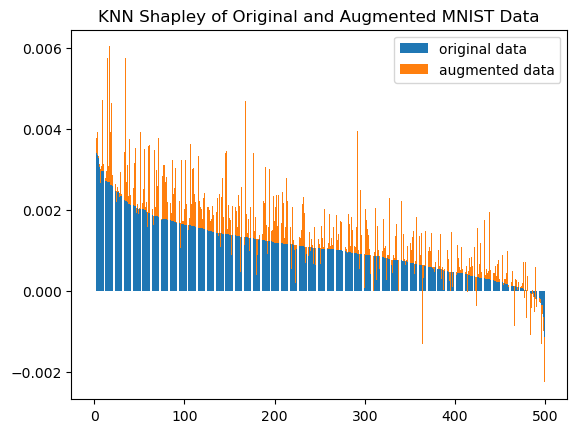

In [20]:
plt.bar(g, ori_high_sv, label='original data')
plt.bar(g, aug_high_sv, bottom=ori_high_sv, label='augmented data')
plt.title('KNN Shapley of Original and Augmented MNIST Data')
plt.legend()
plt.show()

### Concatenate two plots

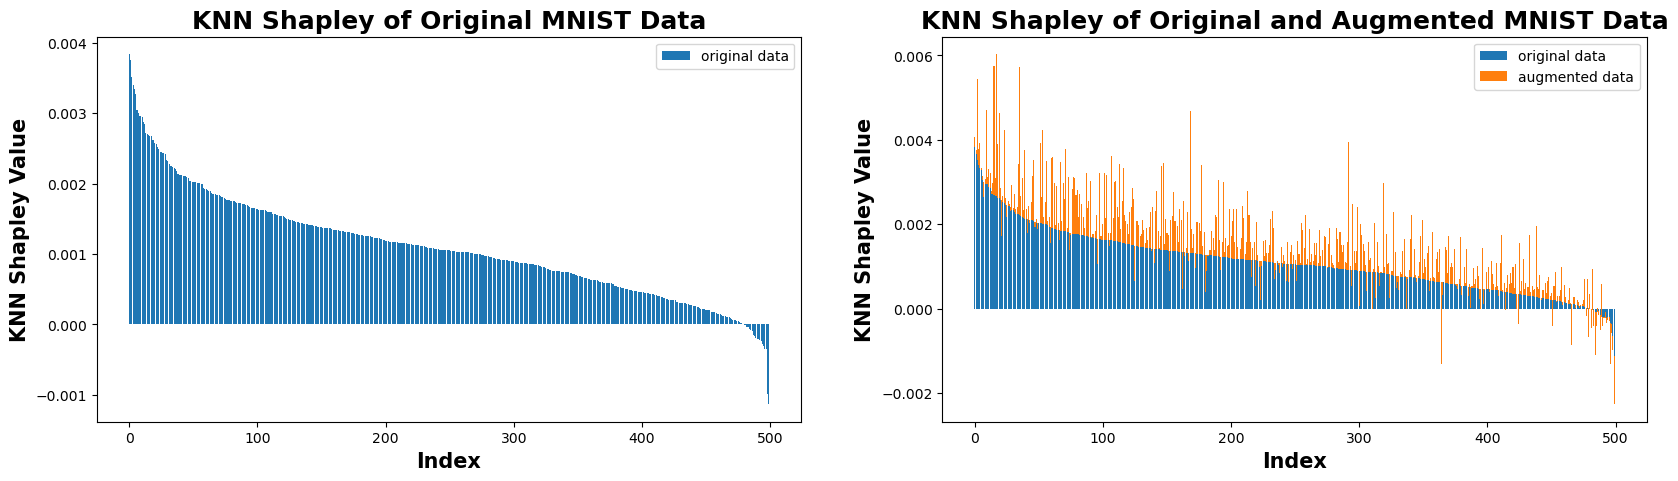

In [33]:
# Define the canvas
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# First subplot
axs[0].bar(g, ori_high_sv, label='original data')
axs[0].set_title('KNN Shapley of Original MNIST Data', 
                 fontsize=18, fontweight='bold')
axs[0].set_xlabel('Index', fontsize=15, fontweight='bold')
axs[0].set_ylabel('KNN Shapley Value', fontsize=15, fontweight='bold')
axs[0].legend()


# Second subplot
axs[1].bar(g, ori_high_sv, label='original data')
axs[1].bar(g, aug_high_sv, bottom=ori_high_sv, label='augmented data')
axs[1].set_title('KNN Shapley of Original and Augmented MNIST Data', 
                 fontsize=18, fontweight='bold')
axs[1].set_xlabel('Index', fontsize=15, fontweight='bold')
axs[1].set_ylabel('KNN Shapley Value', fontsize=15, fontweight='bold')
axs[1].legend()

plt.savefig(fig_directory + 'sv_realistic_data_augmentation_' + param_setting + '.png')
plt.show()

### 2.4

In [22]:
# Load SV and ASV
ori_sv = np.load(directory + 'ori_knn_sv_K={}_'.format(K) + param_setting + '.npy')
ori_aug_sv = np.load(directory + 'ori_aug_knn_sv_K={}_'.format(K) + param_setting + '.npy')

ori_asv = np.load(directory + 'ori_knn_asv_K={}_'.format(K) + param_setting + '.npy')
ori_aug_asv = np.load(directory + 'ori_aug_knn_asv_K={}_'.format(K) + param_setting + '.npy')

In [23]:
# Sanity check

all(ori_sv == ori_asv), sum(ori_sv), sum(ori_asv)

(True, 0.7632000000000005, 0.7632000000000005)

In [24]:
g = [i for i in range(len(ori_asv))]

# rank sv from high to low
ori_asv_idx = np.argsort(ori_asv)[::-1] 
ori_high_asv = ori_asv[ori_asv_idx]

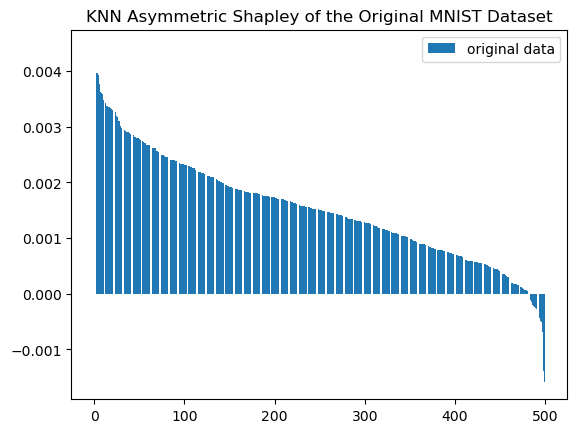

In [25]:
plt.bar(g, ori_high_asv, label='original data')
plt.title('KNN Asymmetric Shapley of the Original MNIST Dataset')
plt.legend()
plt.show()

In [26]:
g = [i for i in range(len(ori_asv))]

# rank sv from high to low
ori_asv_idx = np.argsort(ori_aug_asv[:len(X_ori)])[::-1] 
aug_asv_idx = ori_asv_idx + len(X_ori)

ori_high_asv = ori_aug_asv[ori_asv_idx]
aug_high_asv = ori_aug_asv[aug_asv_idx]

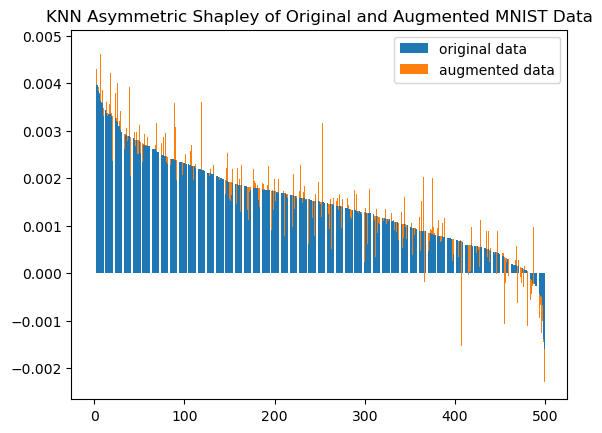

In [27]:
plt.bar(g, ori_high_asv, label='original data')
plt.bar(g, aug_high_asv, bottom=ori_high_asv, label='augmented data')
plt.title('KNN Asymmetric Shapley of Original and Augmented MNIST Data')
plt.legend()
plt.show()

### Concatenate two plots

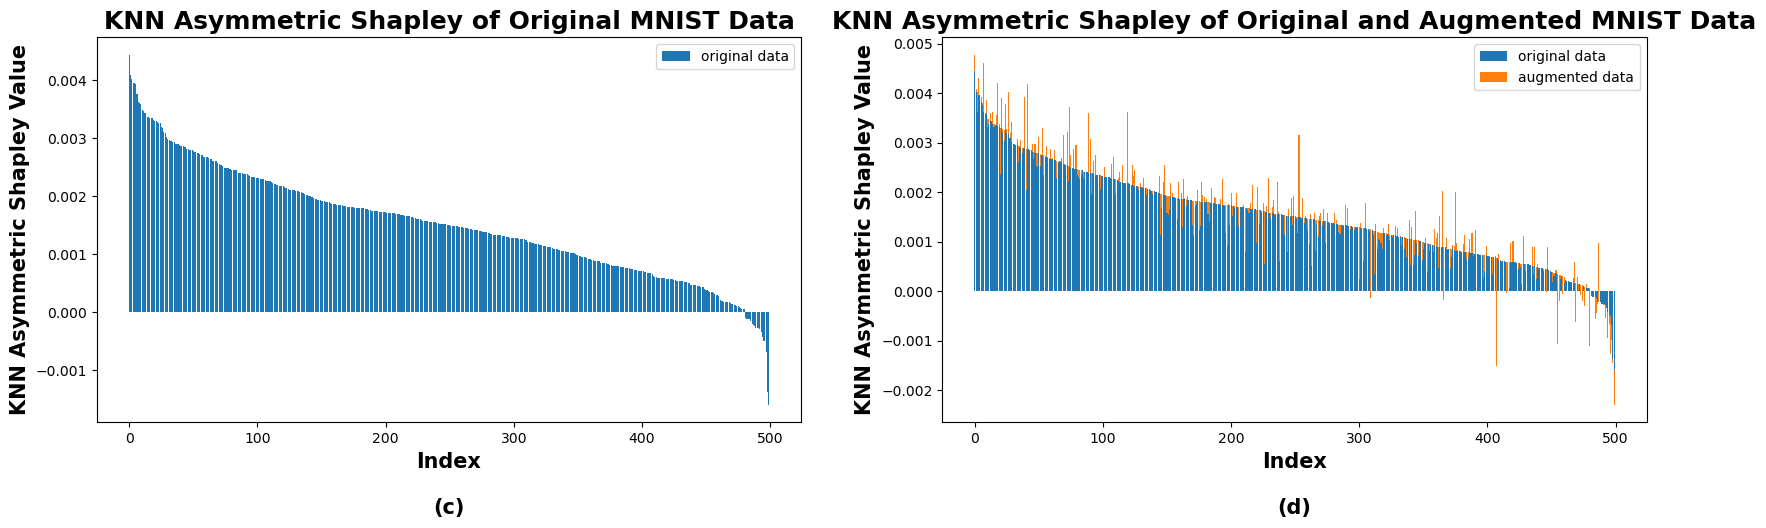

In [38]:
# Define the canvas
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# First subplot
axs[0].bar(g, ori_high_asv, label='original data')
axs[0].set_title('KNN Asymmetric Shapley of Original MNIST Data', 
                 fontsize=18, fontweight='bold')
axs[0].set_xlabel('Index\n\n(c)', fontsize=15, fontweight='bold')
axs[0].set_ylabel('KNN Asymmetric Shapley Value', fontsize=15, fontweight='bold')
axs[0].legend()


# Second subplot
axs[1].bar(g, ori_high_asv, label='original data')
axs[1].bar(g, aug_high_asv, bottom=ori_high_asv, label='augmented data')
axs[1].set_title('KNN Asymmetric Shapley of Original and Augmented MNIST Data', 
                 fontsize=18, fontweight='bold')
axs[1].set_xlabel('Index\n\n(d)', fontsize=15, fontweight='bold')
axs[1].set_ylabel('KNN Asymmetric Shapley Value', fontsize=15, fontweight='bold')
axs[1].legend()


plt.savefig(fig_directory + 'asv_realistic_data_augmentation_' + param_setting + '.png')
plt.show()

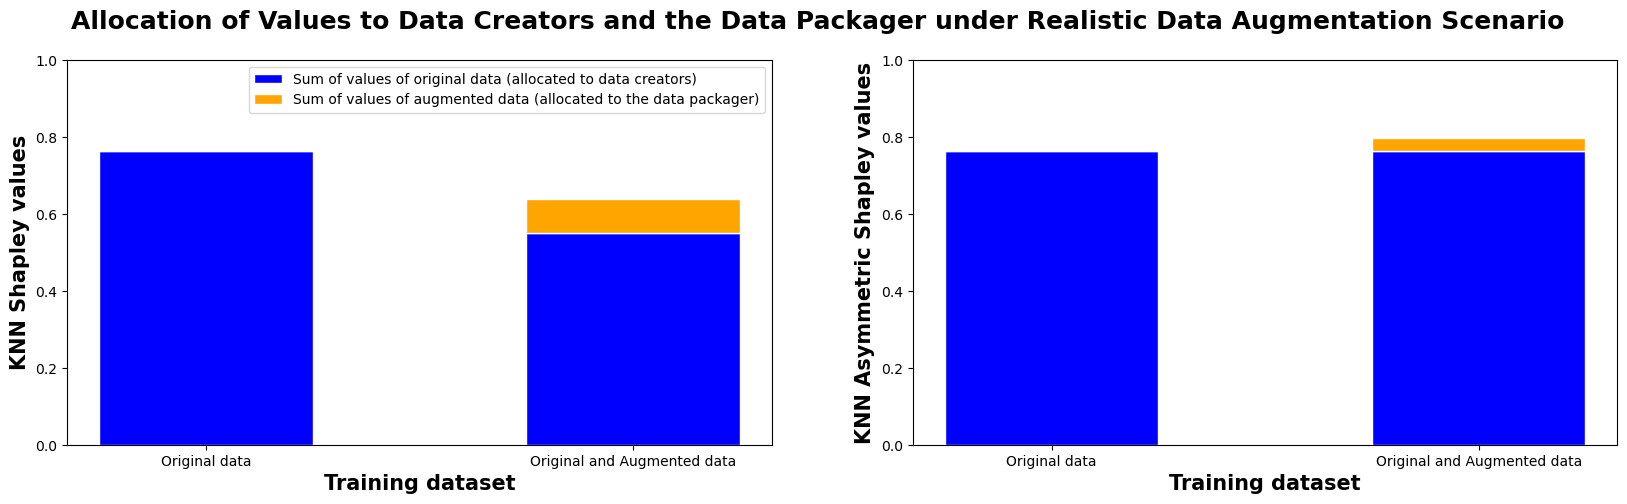

In [43]:
import matplotlib.pyplot as plt
import numpy as np

label_font = 15
title_font = 18

# Data preparation
ratio = int(len(X_aug)*0.1)

aug_high_sv_idx = np.argsort(ori_aug_sv[len(X_ori):])[::-1]
selected_aug_high_sv = ori_aug_sv[len(X_ori):][aug_high_sv_idx][:ratio]

aug_high_asv_idx = np.argsort(ori_aug_asv[len(X_ori):])[::-1]
selected_aug_high_asv = ori_aug_asv[len(X_ori):][aug_high_asv_idx][:ratio]

# Define the canvas
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

categories = ['Original data', 'Original and Augmented data']
bar_width = 0.5

# Heights of the bars in the first plot
ori_svs = [sum(ori_sv), sum(ori_aug_sv[:len(X_ori)])]
aug_svs = [0, sum(selected_aug_high_sv)]

# Positions of the bars on the x-axis
r = np.arange(len(categories))

# Create the stacked bar plot for the first subplot
axs[0].bar(r, ori_svs, color='b', edgecolor='white', width=bar_width, 
           label='Sum of values of original data (allocated to data creators)')
axs[0].bar(r, aug_svs, bottom=ori_svs, color='orange', edgecolor='white', width=bar_width, 
        label='Sum of values of augmented data (allocated to the data packager)')

# Add labels, and legend for the first subplot
axs[0].set_xlabel('Training dataset', fontweight='bold', fontsize=label_font)
axs[0].set_ylabel('KNN Shapley values', fontweight='bold', fontsize=label_font)
axs[0].set_ylim((0, 1))
axs[0].set_xticks(r, categories)
axs[0].legend()

# Heights of the bars in the second plot
ori_asvs = [sum(ori_asv), sum(ori_aug_asv[:len(X_ori)])]
aug_asvs = [0, sum(selected_aug_high_asv)]

# Create the stacked bar plot for the second subplot
axs[1].bar(r, ori_asvs, color='b', edgecolor='white', width=bar_width, 
           label='Sum of values of original data (allocated to data creators)')
axs[1].bar(r, aug_asvs, bottom=ori_asvs, color='orange', edgecolor='white', width=bar_width, 
        label='Sum of values of augmented data (allocated to the data packager)')

# Add labels, and legend for the first subplot
axs[1].set_xlabel('Training dataset', fontweight='bold', fontsize=label_font)
axs[1].set_ylabel('KNN Asymmetric Shapley values', fontweight='bold', fontsize=label_font)
axs[1].set_ylim((0, 1))
axs[1].set_xticks(r, categories)

# Add a single overarching title for the entire figure
fig.suptitle('Allocation of Values to Data Creators and the Data Packager under Realistic Data Augmentation Scenario', 
             fontweight='bold', fontsize = title_font)

# Save figure
plt.savefig(fig_directory + 'barplot_realistic_data_augmentation_' + param_setting + '.png')

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

label_font = 15
title_font = 18

# Data preparation
ratio = int(len(X_aug)*0.1)

aug_high_sv_idx = np.argsort(ori_aug_sv[len(X_ori):])[::-1]
selected_aug_high_sv = ori_aug_sv[len(X_ori):][aug_high_sv_idx][:ratio]

aug_high_asv_idx = np.argsort(ori_aug_asv[len(X_ori):])[::-1]
selected_aug_high_asv = ori_aug_asv[len(X_ori):][aug_high_asv_idx][:ratio]

# Define the canvas
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

categories = ['Original data', 'Original and Augmented data']
bar_width = 0.5

# Heights of the bars in the first plot
ori_svs = [sum(ori_sv), sum(ori_aug_sv[:len(X_ori)])]
aug_svs = [0, sum(selected_aug_high_sv)]

# Positions of the bars on the x-axis
r = np.arange(len(categories))

# Create the stacked bar plot for the first subplot
axs[0].bar(r, ori_svs, color='b', edgecolor='white', width=bar_width, 
           label='Sum of values of original data (allocated to data creators)')
axs[0].bar(r, aug_svs, bottom=ori_svs, color='orange', edgecolor='white', width=bar_width, 
        label='Sum of values of augmented data (allocated to the data packager)')

# Add labels, and legend for the first subplot
axs[0].set_xlabel('Training dataset', fontweight='bold', fontsize=label_font)
axs[0].set_ylabel('KNN Shapley values', fontweight='bold', fontsize=label_font)
axs[0].set_ylim((0, 1))
axs[0].set_xticks(r, categories)
axs[0].legend()

# Heights of the bars in the second plot
ori_asvs = [sum(ori_asv), sum(ori_aug_asv[:len(X_ori)])]
aug_asvs = [0, sum(selected_aug_high_asv)]

# Create the stacked bar plot for the second subplot
axs[1].bar(r, ori_asvs, color='b', edgecolor='white', width=bar_width, 
           label='Sum of values of original data (allocated to data creators)')
axs[1].bar(r, aug_asvs, bottom=ori_asvs, color='orange', edgecolor='white', width=bar_width, 
        label='Sum of values of augmented data (allocated to the data packager)')

# Add labels, and legend for the first subplot
axs[1].set_xlabel('Training dataset', fontweight='bold', fontsize=label_font)
axs[1].set_ylabel('KNN Asymmetric Shapley values', fontweight='bold', fontsize=label_font)
axs[1].set_ylim((0, 1))
axs[1].set_xticks(r, categories)

# Add a single overarching title for the entire figure
fig.suptitle('Allocation of Values to Data Creators and the Data Packager under Realistic Data Augmentation Scenario', 
             fontweight='bold', fontsize = title_font)

# Save figure
plt.savefig(fig_directory + 'barplot_realistic_data_augmentation_' + param_setting + '.png')

# Display the plot
plt.show()

In [74]:
ori_svs = [sum(ori_sv), sum(ori_aug_sv[:len(X_ori)])]
aug_svs = [0, sum(selected_aug_high_sv)]
ori_asvs = [sum(ori_asv), sum(ori_aug_asv[:len(X_ori)])]
aug_asvs = [0, sum(selected_aug_high_asv)]

In [75]:
sum(ori_asv), sum(ori_aug_asv[:len(X_ori)])

(0.8156000000000003, 0.8155999999999994)

In [76]:
sum(selected_aug_high_sv), sum(selected_aug_high_asv)

(0.11131346949858792, 0.04128311311755141)

In [53]:
ratio = int(len(aug_high_sv)*0.25)
sum(ori_high_sv), sum(aug_high_sv[:ratio])

(0.5931101853685532, 0.10769453239579158)

In [54]:
sum(ori_sv)

0.8156000000000003

In [55]:
sum(ori_high_asv), sum(aug_high_asv[:ratio])

(0.8155999999999991, 0.015444225153535348)

In [30]:
sum(ori_aug_sv), sum(ori_aug_asv)

(0.8076000000000015, 0.8075999999999778)